In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import numpy as np

In [3]:
import sys
sys.path.append('..')

from my_code import functions as f

# Data

In [4]:
file_path = '../data/energies/Trial/Strings_Energies_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/100
angles_list = np.array([f.string_to_numbers(string) for string in string_list])

In [5]:
X, Y, X_validation, Y_validation = f.create_validating_set(angles_list, score_list, percentage=0.1)

In [6]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float32)
target_data = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float32)
target_validation = torch.tensor(Y_validation, dtype=torch.float32).view(-1, 1)

# Quantum node

In [7]:
def qml_RZZ(params, wires):
    """
    RZZ gate.
    """
    qml.CNOT(wires=wires)
    qml.RZ(params, wires=wires[1])
    qml.CNOT(wires=wires)

In [8]:
import pennylane as qml

n_qubits = 4
n_layers_block = 50
n_layers_embedding = 3
n_layers = n_layers_block + n_layers_embedding
n_params = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):

    # state preparation (we create an embedding with 3 layers, paper: 2001.03622)
    for i in range(n_layers_embedding):
       
        # angle embedding for each qubit
        qml.AngleEmbedding(inputs, wires=range(n_qubits))

        # ZZ rotation for neighboring qubits         
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,0], wires=[j, (j+1)%n_qubits])

        # rotations for each qubit
        for j in range(n_qubits):
            qml.RY(weights[i,j,1], wires=j)

        # last angle embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    #layers
    for i in range(n_layers_embedding, n_layers):
        # rotations for each qubit
        for j in range(n_qubits):
            qml.RX(weights[i,j,2], wires=j)
            qml.RZ(weights[i,j,3], wires=j)

        # ZZ rotation for neighboring qubits 
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,4], wires=[j, (j+1)%n_qubits])

    # measurement
    return [qml.expval(qml.PauliZ(wires=0))]

In [9]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")([i for i in range(n_qubits)], np.zeros((n_layers, n_qubits, n_params)))
fig.set_size_inches((16,3))

TypeError: unsupported operand type(s) for *: 'ExpectationMP' and 'int'

In [ ]:
weight_shapes = {"weights": (n_layers, n_qubits, n_params)}

In [ ]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Hybrid model

In [ ]:
input_dim = input_data.size(1)

layers =  [nn.Linear(input_dim*1, input_dim*2), nn.ReLU()]
layers += [nn.Linear(input_dim*2, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*2), nn.ReLU()] 
layers += [nn.Linear(input_dim*2, input_dim*1)] 
layers += [qlayer] 
Net = nn.Sequential(*layers)

In [ ]:
# Create an instance of the network
model = Net

In [ ]:
import time

In [ ]:
# time
start_time = time.time()


# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
batch_size = 32

losses = []
losses_epochs = []

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    losses_epochs.append(0)

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):
        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()), end='\r')

        # add to the epoch loss
        losses_epochs[-1] += loss.item() / (input_data.size(0) / batch_size)

    # time
    # Compute elapsed time and remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_epoch = elapsed_time / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining_time = avg_time_per_epoch * remaining_epochs

    # Convert remaining time to hours, minutes, and seconds for better readability
    hours, remainder = divmod(estimated_remaining_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Print the loss and remaining time for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}, Time remaining: ~{}h {}m {:.0f}s'.format(
        epoch+1, num_epochs, losses_epochs[-1], hours, minutes, seconds))


Epoch [1/10], Loss: 0.0534, Time remaining: ~0.0h 55.0m 11s
Epoch [2/10], Loss: 0.0519, Time remaining: ~0.0h 52.0m 24s
Epoch [3/10], Loss: 0.0501, Time remaining: ~0.0h 46.0m 55s
Epoch [4/10], Loss: 0.0487, Time remaining: ~0.0h 40.0m 34s
Epoch [5/10], Loss: 0.0479, Time remaining: ~0.0h 34.0m 3s
Epoch [6/10], Loss: 0.0468, Time remaining: ~0.0h 26.0m 57s
Epoch [7/10], Loss: 0.0464, Time remaining: ~0.0h 20.0m 2s
Epoch [8/10], Loss: 0.0454, Time remaining: ~0.0h 13.0m 17s
Epoch [9/10], Loss: 0.0450, Time remaining: ~0.0h 6.0m 37s
Epoch [10/10], Loss: 0.0446, Time remaining: ~0.0h 0.0m 0s


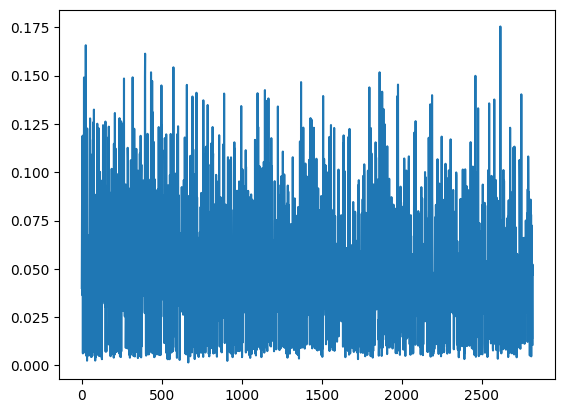

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

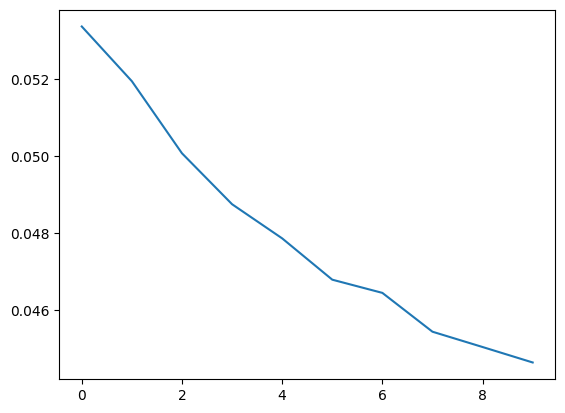

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses_epochs)
plt.show()

In [ ]:
avg_loss = 0
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    loss = criterion(model(i), t)
    avg_loss += loss/len(target_validation)
    print('i: {}, target: {:.3f}, output: {:.3f}, loss: {:.3f}'.format(x, t.item(), model(i).item(), loss))

print('Average loss: {:.3f}'.format(avg_loss))

i: 0, target: 0.052, output: 0.169, loss: 0.014

i: 1, target: -0.066, output: -0.080, loss: 0.000

i: 2, target: 0.955, output: 0.100, loss: 0.732

i: 3, target: 0.014, output: 0.089, loss: 0.006

i: 4, target: -0.004, output: 0.173, loss: 0.031

i: 5, target: -0.125, output: -0.118, loss: 0.000

i: 6, target: -0.149, output: -0.121, loss: 0.001

i: 7, target: -0.058, output: -0.050, loss: 0.000

i: 8, target: -0.071, output: 0.102, loss: 0.030

i: 9, target: -0.040, output: -0.077, loss: 0.001

i: 10, target: -0.192, output: -0.123, loss: 0.005

i: 11, target: -0.030, output: -0.109, loss: 0.006

i: 12, target: -0.280, output: -0.123, loss: 0.025

i: 13, target: 0.922, output: 0.003, loss: 0.845

i: 14, target: -0.060, output: -0.122, loss: 0.004

i: 15, target: -0.181, output: -0.110, loss: 0.005

i: 16, target: -0.176, output: 0.083, loss: 0.067

i: 17, target: -0.060, output: 0.256, loss: 0.100

i: 18, target: -0.120, output: 0.001, loss: 0.015

i: 19, target: -0.111, output: -0.0

# Save the Notebook as a PDF

In [ ]:
# SAVE THE NOTEBOOK

from IPython.display import Javascript

# Define the function to save the notebook
def save_notebook():
    display(Javascript('IPython.notebook.save_notebook()'))

# Call the save_notebook function to save the notebook
save_notebook()

In [ ]:
import subprocess
import os

name_notebook = "0724-small_hybrid_model_v2.ipynb"  

output_filename = "results/"+ name_notebook[:4] +"/" + name_notebook[:-6] + "_0.pdf"

#check if the output file already exists
while os.path.exists(output_filename):
    print("The file {} already exists".format(output_filename))
    output_filename = output_filename[:-5] + str(int(output_filename[-5]) + 1) + ".pdf"
    print("Trying to save the file as {}".format(output_filename))
    

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", output_filename, name_notebook])




CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'results/0724/0724-small_hybrid_model_v2_0.pdf', '0724-small_hybrid_model_v2.ipynb'], returncode=0)